In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import pylab
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
url_train = "https://github.com/PabloJRW/titanic-classifier/raw/main/train.csv"
url_test = "https://github.com/PabloJRW/titanic-classifier/raw/main/test.csv"
df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)

# <b>EDA</b>

In [3]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# non-nulls values and data type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Train dataset dimension
df_train.shape

(891, 12)

The dataset contains 12 columns consisting of both numerical and categorical data, with a total of 891 entries. However, some columns contain null values which need to be accounted for in the analysis.

In [6]:
# Missing values
df_train.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

The following columns in the dataset contain missing values:

"Cabin": 687 missing values <br>
"Age": 177 missing values<br>
"Embarked": 2 missing values

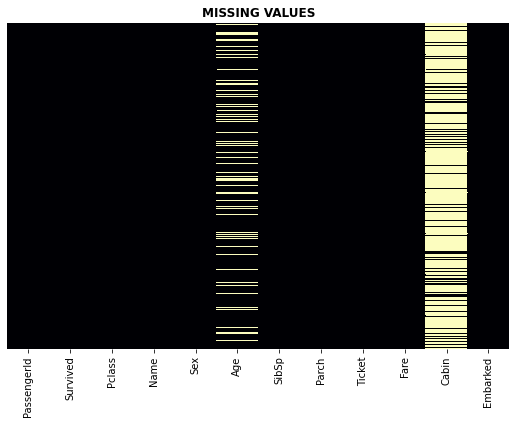

In [7]:
# Missing values visualization
plt.figure(figsize=(9,6))
plt.title('MISSING VALUES', fontweight='bold')
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='magma')
plt.show()

In [47]:
# Importing regular expression library
import re

def extract_title(text):
    """
    Extract the social title from name.
    E.g Mr, Mrs, Miss
    """
    pattern = r",\s(.+?)\s"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return ""

In [50]:
# Extracting social title from the name
df_train['social_title'] = df_train['Name'].apply(extract_title)
df_train.title.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: title, dtype: int64

## <b> Numerical Features

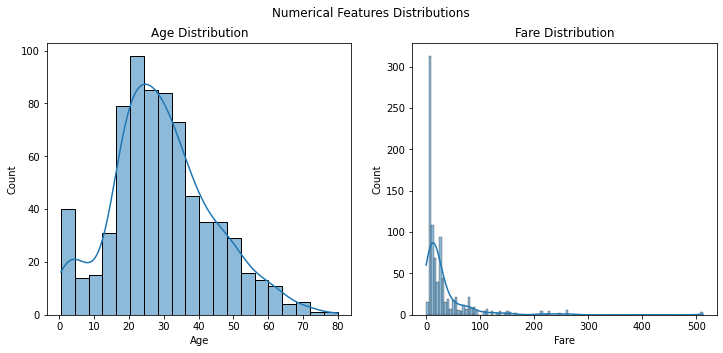

In [8]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Create the first scatter plot
sns.histplot(df_train.Age.dropna(), kde=True, ax=axs[0])
axs[0].set_title('Age Distribution')

# Create the second scatter plot
sns.histplot(df_train.Fare, kde=True, ax=axs[1])
axs[1].set_title('Fare Distribution')

# Add overall title for the figure
fig.suptitle('Numerical Features Distributions')

# Display the plots
plt.show()


In [9]:
df_train[['Age','Fare']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


I am going to perform a <b>t-test</b> over the "age" and "fare" variables to investigate whether there are any significant differences between passengers that survived and those who did not. <b>t-test</b> will allow me to compare the means of these variables across the two groups, and determine whether any observed differences are statistically significant. By testing for differences between these variables, I can gain insight into whether age and fare played a role in the likelihood of surviving the Titanic disaster.

To achieve the normality assumptions required to perform a <b>t-test</b>, I am going to check for normality using the Shapiro-Wilk test in my "age" and "fare" variables before performing a <b>t-test</b>. The Shapiro-Wilk test is a commonly used normality test that can determine whether a sample of data is drawn from a normal distribution. By testing for normality, I can determine whether the data is suitable for a <b>t-test</b>, and whether any transformations or adjustments need to be made to the data before proceeding with the test.

In [10]:
# Normality test - Shapiro-Wilk Test 
def normality_results(data):
  """
  Apply Shapiro-Wilk test
  """
  stat, p = stats.shapiro(data)

  # print test statistics and p-value
  print(f"Shapiro-Wilk test statistic: {stat:.4f}")
  print(f"p-value: {p:.4f}")
  if p > 0.05:
    print("Data is normally distributed")
  else:
    print("Data is not normally distributed")

In [11]:
# Checking for normality - Age variable
normality_results(df_train.Age.dropna())

print('')
# Checking for normality - Age variable
normality_results(df_train.Fare.dropna())

Shapiro-Wilk test statistic: 0.9815
p-value: 0.0000
Data is not normally distributed

Shapiro-Wilk test statistic: 0.5219
p-value: 0.0000
Data is not normally distributed


Based on the results of the Shapiro-Wilk test, the "age" and "Fare" variables are not normally distributed. Therefore, to investigate differences between passengers that survived and those who did not, it is not appropriate to perform an <b>t-test</b>, which assumes normality.

Due to the non-normal distribution of the age and fare variables, the Mann-Whitney U test will be performed to analyze the relationship between these variables.

In [12]:
# Survivors and non survivors groups - Age
age_survived = df_train[df_train['Survived'] == 1]['Age'].dropna() # Age of survivors
age_no_survived = df_train[df_train['Survived'] == 0]['Age'].dropna() # Age of non-survivors

# Survivors and non survivors groups - Fare
fare_survived = df_train[df_train['Survived'] == 1]['Fare'] # Fare paid for survivors
fare_no_survived = df_train[df_train['Survived'] == 0]['Fare'] # Fare paid for non-survivors

In [13]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U test
def mann_whitney_test(group1, group2):
    """ Perform the Mann-Whitney U test """
    stat, p = mannwhitneyu(group1, group2)
    
    # Print the test results
    print("Mann-Whitney U test:")
    print("Test statistic:", stat)
    print("p-value:", p)
    
    # Interpret the results
    alpha = 0.05
    if p < alpha:
        print("There is a significant difference between the two groups.")
    else:
        print("There is no significant difference between the two groups.")
    
    return stat, p


### Age

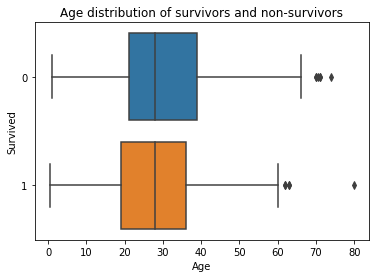

In [28]:
plt.figure()
sns.boxplot(x=df_train.Age, y=df_train.Survived, orient='h')
plt.title('Age distribution of survivors and non-survivors')
plt.show()

In [15]:
# Mann-Whitney U test - Age
mann_whitney_test(age_survived, age_no_survived)

Mann-Whitney U test:
Test statistic: 57682.0
p-value: 0.16049252477737763
There is no significant difference between the two groups.


(57682.0, 0.16049252477737763)

Based on the results of the Mann-Whitney U test performed on the age variable of passengers who survived and those who did not, we can see that the test statistic is 57682.0 and the p-value is 0.16049252477737763.

The p-value is greater than the typical significance level of 0.05, indicating that there is no statistically significant difference in age between the passengers who survived and those who did not.

Therefore, we fail to reject the null hypothesis that the two groups come from the same distribution. In other words, we can conclude that age does not appear to be a significant factor in determining the likelihood of survival on the Titanic.

### Fare

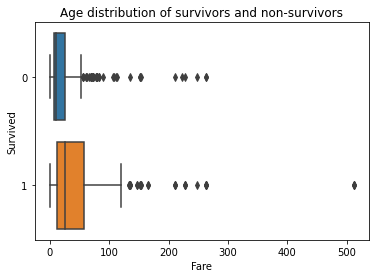

In [16]:
plt.figure()
sns.boxplot(y=df_train.Survived, x=df_train.Fare, orient='h')
plt.title('Age distribution of survivors and non-survivors')
plt.show()

In [17]:
# Mann-Whitney U test - Fare
mann_whitney_test(fare_survived, fare_no_survived)

Mann-Whitney U test:
Test statistic: 129951.5
p-value: 4.553477179250237e-22
There is a significant difference between the two groups.


(129951.5, 4.553477179250237e-22)

Based on the results of the Mann-Whitney U test performed on the fare variable of passengers who survived and those who did not, we can see that the test statistic is 129951.5 and the p-value is 4.553477179250237e-22.

The p-value is less than the typical significance level of 0.05, indicating that there is a statistically significant difference in fare between the passengers who survived and those who did not.

Therefore, we reject the null hypothesis that the two groups come from the same distribution. In other words, we can conclude that fare appears to be a significant factor in determining the likelihood of survival on the Titanic.

## <b>Categorical Features

I am going to perform a chi-square test to determine if the categorical variables are correlated to the target variable. The chi-square test is a statistical measure used to determine the association between two categorical variables and to determine if they are independent or not. By performing this test, we can see if there is a significant correlation between the categorical variable and the target variable, which can provide insight into the relationship between these variables.

In [18]:
from scipy.stats import chi2_contingency

def chi2_test(predictor, target):
  # Create a contingency table from the two categorical features
  contingency_table = pd.crosstab(predictor, target)

  # Perform the chi-square test of independence
  stat, p, dof, expected = chi2_contingency(contingency_table)

  # Print the test results
  print("Chi-square test results:")
  print("Test statistic:", stat)
  print("p-value:", p)
  print("Degrees of freedom:", dof)
  print("Expected frequencies:\n", expected)

### Pclass

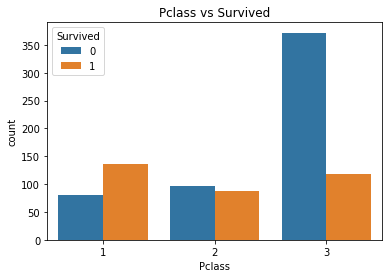

In [19]:
plt.figure()
sns.countplot( x=df_train.Pclass,  hue=df_train.Survived)
plt.title('Pclass vs Survived')
plt.show()

In [20]:
# Chi2 test - Pclass vs Survived
chi2_test(df_train.Pclass, df_train.Survived)

Chi-square test results:
Test statistic: 102.88898875696056
p-value: 4.549251711298793e-23
Degrees of freedom: 2
Expected frequencies:
 [[133.09090909  82.90909091]
 [113.37373737  70.62626263]
 [302.53535354 188.46464646]]


The Chi-square test was performed to determine if there is a significant correlation between the passenger class predictor and the survived target variable.

The test results show that the test statistic is 102.88898875696056, with a p-value of 4.549251711298793e-23 and 2 degrees of freedom. This indicates that there is a significant correlation between the passenger class and survival, as the p-value is much smaller than the typical significance level of 0.05.

In summary, the Chi-square test results suggest that there is a significant correlation between passenger class and survival on the Titanic. Specifically, the results suggest that passengers in higher classes (i.e., class 1) had a higher chance of survival, while those in lower classes (i.e., class 3) had a lower chance of survival.

### Sex

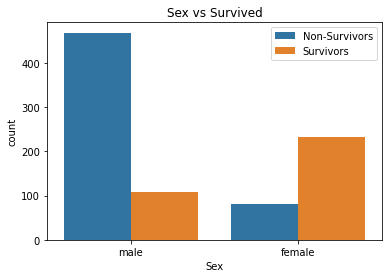

In [21]:
plt.figure()
sns.countplot( x=df_train.Sex,  hue=df_train.Survived)
plt.title('Sex vs Survived')
plt.legend(['Non-Survivors', 'Survivors'])
plt.show()

In [22]:
# Chi2 test - Sex vs Survived
chi2_test(df_train.Sex, df_train.Survived)

Chi-square test results:
Test statistic: 260.71702016732104
p-value: 1.1973570627755645e-58
Degrees of freedom: 1
Expected frequencies:
 [[193.47474747 120.52525253]
 [355.52525253 221.47474747]]


The Chi-square test was performed to determine if there is a significant correlation between the sex variable and the survived variable.

The interpretation of these results is that there is a significant correlation between sex and survival on the Titanic. Specifically, the results suggest that female passengers had a higher chance of survival than male passengers. This finding is consistent with the well-known fact that the "women and children first" policy was followed during the Titanic disaster.

## Embarked

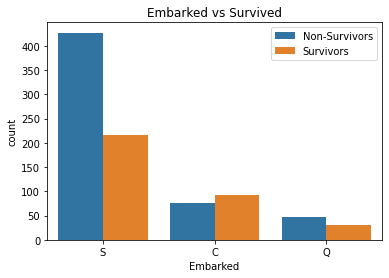

In [23]:
plt.figure()
sns.countplot(x=df_train.Embarked,  hue=df_train.Survived)
plt.title('Embarked vs Survived')
plt.legend(['Non-Survivors', 'Survivors'])
plt.show()

In [24]:
# Chi2 test - Embarked vs Survived
chi2_test(df_train.Embarked, df_train.Survived)

Chi-square test results:
Test statistic: 26.48914983923762
p-value: 1.769922284120912e-06
Degrees of freedom: 2
Expected frequencies:
 [[103.7480315  64.2519685]
 [ 47.5511811  29.4488189]
 [397.7007874 246.2992126]]


The chi-square test was conducted to investigate the relationship between the variables "embarked" (port of embarkation) and "survived" (whether or not a passenger survived) in a dataset. The test statistic was found to be 26.49, with a corresponding p-value of 1.77e-06 and degrees of freedom equal to 2.

To interpret the results, we can compare the p-value to a significance level (e.g., α = 0.05) to determine whether or not to reject the null hypothesis of independence. In this case, the p-value is much smaller than 0.05, indicating strong evidence against the null hypothesis. Therefore, we can conclude that there is a statistically significant association between the "embarked" and "survived" variables.

## SibSp

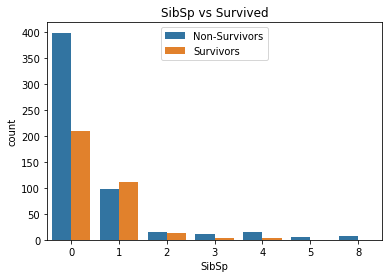

In [26]:
plt.figure()
sns.countplot(x=df_train.SibSp,  hue=df_train.Survived)
plt.title('SibSp vs Survived')
plt.legend(['Non-Survivors', 'Survivors'])
plt.show()

In [27]:
# Chi2 test - SibSp vs Survived
chi2_test(df_train.SibSp, df_train.Survived)

Chi-square test results:
Test statistic: 37.2717929152043
p-value: 1.5585810465902147e-06
Degrees of freedom: 6
Expected frequencies:
 [[374.62626263 233.37373737]
 [128.77777778  80.22222222]
 [ 17.25252525  10.74747475]
 [  9.85858586   6.14141414]
 [ 11.09090909   6.90909091]
 [  3.08080808   1.91919192]
 [  4.31313131   2.68686869]]


The chi-square test was conducted to investigate the relationship between the variables "SibSp" (number of siblings/spouses aboard) and "survived" (whether or not a passenger survived) in a dataset. The test statistic was found to be 37.27, with a corresponding p-value of 1.56e-06 and degrees of freedom equal to 6.

To interpret the results, we can compare the p-value to a significance level (e.g., α = 0.05) to determine whether or not to reject the null hypothesis of independence. In this case, the p-value is much smaller than 0.05, indicating strong evidence against the null hypothesis. Therefore, we can conclude that there is a statistically significant association between the "SibSp" and "survived" variables.

The expected frequencies can also be examined to gain insight into the nature of the association. For example, we can see that the expected number of survivors decreases as the number of siblings/spouses aboard increases. This suggests that passengers with more siblings/spouses aboard were less likely to survive than those with fewer siblings/spouses aboard.

## Parch

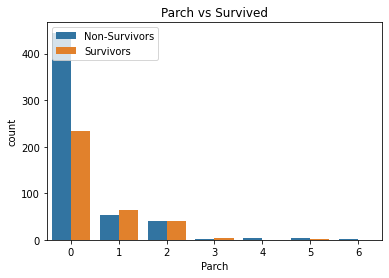

In [29]:
plt.figure()
sns.countplot(x=df_train.Parch,  hue=df_train.Survived)
plt.title('Parch vs Survived')
plt.legend(['Non-Survivors', 'Survivors'])
plt.show()

In [30]:
# Chi2 test - Parch vs Survived
chi2_test(df_train.Parch, df_train.Survived)

Chi-square test results:
Test statistic: 27.925784060236168
p-value: 9.703526421039997e-05
Degrees of freedom: 6
Expected frequencies:
 [[4.17757576e+02 2.60242424e+02]
 [7.27070707e+01 4.52929293e+01]
 [4.92929293e+01 3.07070707e+01]
 [3.08080808e+00 1.91919192e+00]
 [2.46464646e+00 1.53535354e+00]
 [3.08080808e+00 1.91919192e+00]
 [6.16161616e-01 3.83838384e-01]]


To interpret the results, we can compare the p-value to a significance level (e.g., α = 0.05) to determine whether or not to reject the null hypothesis of independence. In this case, the p-value is much smaller than 0.05, indicating strong evidence against the null hypothesis. Therefore, we can conclude that there is a statistically significant association between the "Parch" (number of parents/children aboard) and "survived" (whether or not a passenger survived) variables.

The expected frequencies can also be examined to gain insight into the nature of the association. For example, we can see that the expected number of survivors decreases as the number of parents/children aboard increases. This suggests that passengers with more parents/children aboard were less likely to survive than those with fewer parents/children aboard. However, it is important to note that the expected frequencies are based on the assumption of independence, so deviations from these values do not necessarily indicate a causal relationship between the variables.

In [31]:
# Create a contingency table of SibSp and Parch
cont_table = pd.crosstab(df_train['SibSp'], df_train['Parch'])

# Display the contingency table
print(cont_table)

Parch    0   1   2  3  4  5  6
SibSp                         
0      537  38  29  1  1  2  0
1      123  57  19  3  3  3  1
2       16   7   4  1  0  0  0
3        2   7   7  0  0  0  0
4        0   9   9  0  0  0  0
5        0   0   5  0  0  0  0
8        0   0   7  0  0  0  0


In [44]:
# Calculate the chi-square test statistic and p-value
chi2, p, dof, expected = chi2_contingency(cont_table)

# Calculate Cramer's V
n = np.sum(cont_table)
phi = np.sqrt(chi2 / (n * (min(cont_table.shape) - 1)))
v = phi / np.sqrt(min(cont_table.shape) - 1)

# Display the results
print("Cramer's V = ")
print(v)
print("p-value = {:.3f}".format(p))

Cramer's V = 
Parch
0    0.118316
1    0.283608
2    0.344441
3    1.377764
4    1.540387
5    1.377764
6    3.080774
dtype: float64
p-value = 0.000


### Social title

"Social title" is a term that is sometimes used to refer to the title or form of address used to address a person in a social or professional context.

In [53]:
# Contingency table
title_survived_crosstab = pd.crosstab(df_train.social_title, df_train.Survived) 
title_survived_crosstab

Survived,0,1
social_title,,
Capt.,1,0
Col.,1,1
Don.,1,0
Dr.,4,3
Jonkheer.,1,0
Lady.,0,1
Major.,1,1
Master.,17,23
Miss.,55,127


In [54]:
# Chi2 test - social_title vs Survived
chi2_test(df_train.social_title, df_train.Survived)

Chi-square test results:
Test statistic: 300.02302134972405
p-value: 2.522768232466142e-54
Degrees of freedom: 16
Expected frequencies:
 [[  0.61616162   0.38383838]
 [  1.23232323   0.76767677]
 [  0.61616162   0.38383838]
 [  4.31313131   2.68686869]
 [  0.61616162   0.38383838]
 [  0.61616162   0.38383838]
 [  1.23232323   0.76767677]
 [ 24.64646465  15.35353535]
 [112.14141414  69.85858586]
 [  1.23232323   0.76767677]
 [  0.61616162   0.38383838]
 [318.55555556 198.44444444]
 [ 77.02020202  47.97979798]
 [  0.61616162   0.38383838]
 [  3.6969697    2.3030303 ]
 [  0.61616162   0.38383838]
 [  0.61616162   0.38383838]]


This is a chi-square test result for the association between social title and survival status. The test statistic is 300.023 with 16 degrees of freedom, which indicates a strong association between these two variables. The p-value is 2.522768232466142e-54, which is very small, suggesting that we can reject the null hypothesis that there is no association between social title and survival status.

## Conclusion